### CAREFUL! Does not converge with same accuracy as vanilla PyTorch

In [38]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm 
import numpy as np
from skimage.transform import resize

import matplotlib.pyplot as plt
import matplotlib

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3,4" #avoid GPUS used by others
from sklearn.utils import shuffle

In [2]:
plt.style.use('seaborn-white')
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20
plt.viridis()

<Figure size 432x288 with 0 Axes>

In [3]:
def plot3(data,titles):
    if(len(titles)<3):
        titles=["Plot1", "Plot2", "Plot3"]
    fig,ax = plt.subplots(1,3, figsize=(20,12))
    im=ax[0].imshow(data[0])
    ax[0].set_title(titles[0])
    ax[0].axis('off')
    plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)
    im=ax[1].imshow(data[1])
    ax[1].set_title(titles[1])
    ax[1].axis('off')
    plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
    im=ax[2].imshow(data[2])
    ax[2].set_title(titles[2])
    ax[2].axis('off')
    plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)

In [4]:
EPOCHS = 60
NGPUS = 2
NGPUS = min(torch.cuda.device_count(), NGPUS)
BATCH_SIZE = NGPUS * 64
LR = NGPUS * 1e-3
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

GPUs: 2 Batch size: 128 Learning rate: 0.002


In [5]:
H,W = 64,64
NLINES = 100 #How many lines of data to use for training?
NLTEST = 60 #How many lines for the test set?

N_VALID = 805 #How much to reserve for validation

In [6]:
path = os.getcwd()

MODEL_SAVE_PATH = path +'/trained_model/'
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)

In [7]:
data_diffr = np.load(path+'/../../data/20191008_39_diff.npz')['arr_0']
real_space = np.load(path+'/../../data/20191008_39_amp_pha_10nm_full.npy')
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

In [8]:
print(data_diffr.shape)
#plt.matshow(np.log10(data_diffr[0,0]))

data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), float)
for i in tqdm(range(data_diffr.shape[0])):
    for j in range(data_diffr.shape[1]):
        data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
        data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])

(161, 161, 256, 256)


100%|██████████| 161/161 [00:17<00:00,  9.11it/s]


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


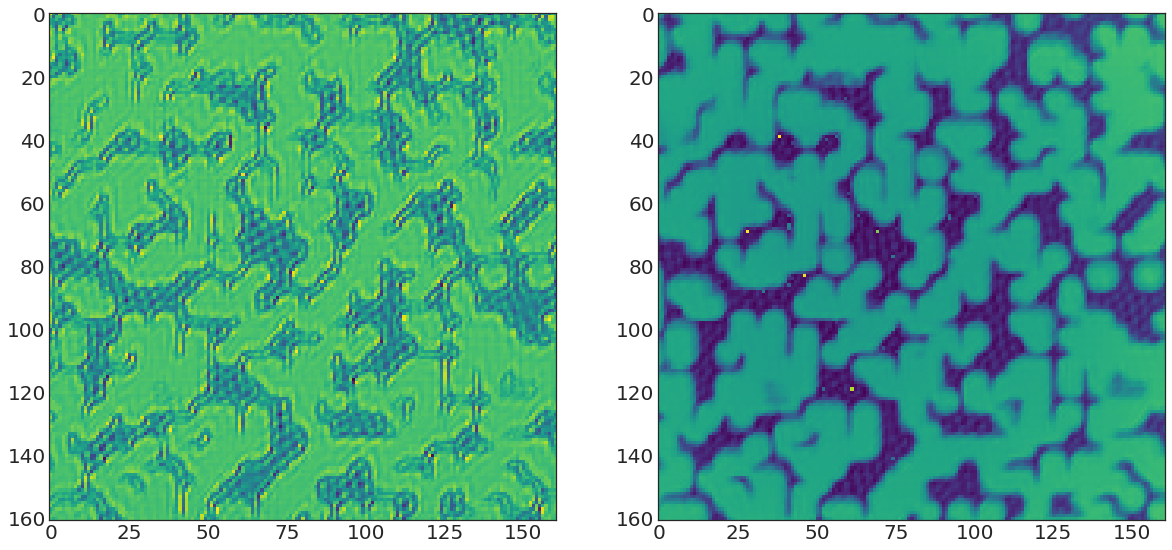

In [9]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(amp[:,:,32,32])
ax[1].imshow(ph[:,:,32,32])

In [10]:
tst_strt = amp.shape[0]-NLTEST #Where to index from
print(tst_strt)

X_train = data_diffr_red[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_train = amp[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_train = ph[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

101
(16100, 1, 64, 64) (3600, 1, 64, 64)


In [11]:
#Training data
X_train_tensor = torch.Tensor(X_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 
Y_phi_train_tensor = torch.Tensor(Y_phi_train)

#Test data
X_test_tensor = torch.Tensor(X_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 
Y_phi_test_tensor = torch.Tensor(Y_phi_test)

print(Y_phi_train.max(), Y_phi_train.min())

print(X_train_tensor.shape, Y_I_train_tensor.shape, Y_phi_train_tensor.shape)

train_data = TensorDataset(X_train_tensor,Y_I_train_tensor,Y_phi_train_tensor)
test_data = TensorDataset(X_test_tensor)

3.1268637 -1.564053
torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64])


In [12]:
N_TRAIN = X_train_tensor.shape[0]
train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-N_VALID,N_VALID])
print(len(train_data2),len(valid_data),len(test_data))

15295 805 3600


In [13]:
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [14]:
nconv = 32


class recon_model(nn.Module):

    def __init__(self):
        super(recon_model, self).__init__()


        self.encoder = nn.Sequential( # Appears sequential has similar functionality as TF avoiding need for separate model definition and activ
          nn.Conv2d(in_channels=1, out_channels=nconv, kernel_size=3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv, nconv, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),          
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv*2, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),          
          nn.ReLU(),
          nn.MaxPool2d((2,2)),
          )

        self.decoder1 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)),
          nn.Sigmoid() #Amplitude model
          )

        self.decoder2 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)),
          nn.Tanh() #Phase model
          )
    
    def forward(self,x):
        x1 = self.encoder(x)
        amp = self.decoder1(x1)
        ph = self.decoder2(x1)

        #Restore -pi to pi range
        ph = ph*np.pi #Using tanh activation (-1 to 1) for phase so multiply by pi

        return amp,ph

In [15]:
model = recon_model()
for ft_images,amps,phs in trainloader:
    print("batch size:", ft_images.shape)
    amp, ph = model(ft_images)
    print(amp.shape, ph.shape)
    print(amp.dtype, ph.dtype)
    break

batch size: torch.Size([128, 1, 64, 64])
torch.Size([128, 1, 64, 64]) torch.Size([128, 1, 64, 64])
torch.float32 torch.float32


In [16]:
summary(model,(1,H,W),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 32, 64, 64]           9,248
              ReLU-4           [-1, 32, 64, 64]               0
         MaxPool2d-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          18,496
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,928
              ReLU-9           [-1, 64, 32, 32]               0
        MaxPool2d-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]          73,856
             ReLU-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,584
             ReLU-14          [-1, 128,

In [37]:
#Function to update saved model if validation loss is minimum
def update_saved_model(model, path):
    if not os.path.isdir(path):
        os.mkdir(path)
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))
    if (NGPUS>1):    
        torch.save(model.module.state_dict(),path+'best_model.pth') #Have to save the underlying model else will always need 4 GPUs
    else:
        torch.save(model,path+'best_model.pth')

def calc_step_size():
  iterations_per_epoch = np.floor((N_TRAIN-N_VALID)/BATCH_SIZE)+1 
  #Final batch will be less than batch size
  step_size = 6*iterations_per_epoch 
  #Paper recommends 2-10 number of iterations, step_size is half cycle
  return step_size, iterations_per_epoch

In [19]:
metrics = {'losses':[],'val_losses':[], 'lrs':[], 'best_val_loss' : np.inf}
from pytorch_lightning.lite import LightningLite

class Lite(LightningLite):

  def train(self, model, optimizer, scheduler, criterion, trainloader,metrics):
    tot_loss = 0.0
    loss_amp = 0.0
    loss_ph = 0.0
    
    for i, (ft_images,amps,phs) in tqdm(enumerate(trainloader)):

        pred_amps, pred_phs = model(ft_images) #Forward pass

        #Compute losses
        loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        loss_p = criterion(pred_phs,phs) #Monitor phase loss but only within support (which may not be same as true amp)
        loss = loss_a + loss_p #Use equiweighted amps and phase

        #Zero current grads and do backprop
        optimizer.zero_grad() 
        #loss.backward()
        self.backward(loss) #Lite needs this
        optimizer.step()

        tot_loss += loss.detach().item()
        loss_amp += loss_a.detach().item()
        loss_ph += loss_p.detach().item()

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i,loss_amp/i,loss_ph/i]) 
    

  def validate(self, model, criterion, validloader,metrics):
      tot_val_loss = 0.0
      val_loss_amp = 0.0
      val_loss_ph = 0.0

      for j, (ft_images,amps,phs) in enumerate(validloader):

          pred_amps, pred_phs = model(ft_images) #Forward pass
      
          val_loss_a = criterion(pred_amps,amps) 
          val_loss_p = criterion(pred_phs,phs)
          val_loss = val_loss_a + val_loss_p
      
          tot_val_loss += val_loss.detach().item()
          val_loss_amp += val_loss_a.detach().item()
          val_loss_ph += val_loss_p.detach().item()  
      metrics['val_losses'].append([tot_val_loss/j,val_loss_amp/j,val_loss_ph/j])
  
    #Update saved model if val loss is lower
      if(tot_val_loss/j<metrics['best_val_loss']):
          print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
          metrics['best_val_loss'] = tot_val_loss/j
          update_saved_model(model, MODEL_SAVE_PATH)

  def run(self, EPOCHS, trainloader, validloader):

    model = recon_model()

    #Optimizer details
    step_size, iterations_per_epoch = calc_step_size()
    print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr = LR)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR/10, max_lr=LR, step_size_up=step_size,
                                                  cycle_momentum=False, mode='triangular2')

    model, optimizer = self.setup(model, optimizer)

    #Scale dataloaders
    trainloader = self.setup_dataloaders(trainloader)
    validloader = self.setup_dataloaders(validloader)

    for epoch in range (EPOCHS):
        
      #Set model to train mode
      model.train() 
      #Training loop
      self.train(model, optimizer, scheduler, criterion, trainloader,metrics)
        
      #Switch model to eval mode
      model.eval()
      #Validation loop
      self.validate(model, criterion, validloader, metrics)
      
      print('Epoch: %d | FT  | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))
      print('Epoch: %d | Amp | Train Loss: %.4f | Val Loss: %.4f' %(epoch, metrics['losses'][-1][1], metrics['val_losses'][-1][1]))
      print('Epoch: %d | Ph  | Train Loss: %.3f | Val Loss: %.3f' %(epoch, metrics['losses'][-1][2], metrics['val_losses'][-1][2]))
      print('Epoch: %d | Ending LR: %.6f ' %(epoch, metrics['lrs'][-1][0]))

In [20]:

Lite(strategy='dp', devices=NGPUS, accelerator="gpu").run(EPOCHS, trainloader, validloader)

LR step size is: 720.0 which is every 6 epochs


120it [00:11, 10.25it/s]


Saving improved model after Val Loss improved from inf to 0.84389
Epoch: 0 | FT  | Train Loss: 0.78005 | Val Loss: 0.84389
Epoch: 0 | Amp | Train Loss: 0.1009 | Val Loss: 0.1011
Epoch: 0 | Ph  | Train Loss: 0.679 | Val Loss: 0.743
Epoch: 0 | Ending LR: 0.000500 


120it [00:04, 26.34it/s]


Saving improved model after Val Loss improved from 0.84389 to 0.62369
Epoch: 1 | FT  | Train Loss: 0.66928 | Val Loss: 0.62369
Epoch: 1 | Amp | Train Loss: 0.0851 | Val Loss: 0.0236
Epoch: 1 | Ph  | Train Loss: 0.584 | Val Loss: 0.600
Epoch: 1 | Ending LR: 0.000800 


120it [00:04, 25.90it/s]


Saving improved model after Val Loss improved from 0.62369 to 0.50956
Epoch: 2 | FT  | Train Loss: 0.47212 | Val Loss: 0.50956
Epoch: 2 | Amp | Train Loss: 0.0110 | Val Loss: 0.0096
Epoch: 2 | Ph  | Train Loss: 0.461 | Val Loss: 0.500
Epoch: 2 | Ending LR: 0.001100 


120it [00:04, 26.60it/s]


Saving improved model after Val Loss improved from 0.50956 to 0.44181
Epoch: 3 | FT  | Train Loss: 0.39706 | Val Loss: 0.44181
Epoch: 3 | Amp | Train Loss: 0.0074 | Val Loss: 0.0082
Epoch: 3 | Ph  | Train Loss: 0.390 | Val Loss: 0.434
Epoch: 3 | Ending LR: 0.001400 


120it [00:04, 25.68it/s]


Saving improved model after Val Loss improved from 0.44181 to 0.40772
Epoch: 4 | FT  | Train Loss: 0.35595 | Val Loss: 0.40772
Epoch: 4 | Amp | Train Loss: 0.0071 | Val Loss: 0.0077
Epoch: 4 | Ph  | Train Loss: 0.349 | Val Loss: 0.400
Epoch: 4 | Ending LR: 0.001700 


120it [00:04, 25.84it/s]


Saving improved model after Val Loss improved from 0.40772 to 0.37760
Epoch: 5 | FT  | Train Loss: 0.32694 | Val Loss: 0.37760
Epoch: 5 | Amp | Train Loss: 0.0068 | Val Loss: 0.0085
Epoch: 5 | Ph  | Train Loss: 0.320 | Val Loss: 0.369
Epoch: 5 | Ending LR: 0.002000 


120it [00:04, 25.94it/s]


Saving improved model after Val Loss improved from 0.37760 to 0.35141
Epoch: 6 | FT  | Train Loss: 0.29492 | Val Loss: 0.35141
Epoch: 6 | Amp | Train Loss: 0.0065 | Val Loss: 0.0074
Epoch: 6 | Ph  | Train Loss: 0.288 | Val Loss: 0.344
Epoch: 6 | Ending LR: 0.001700 


120it [00:04, 25.02it/s]


Saving improved model after Val Loss improved from 0.35141 to 0.31258
Epoch: 7 | FT  | Train Loss: 0.26105 | Val Loss: 0.31258
Epoch: 7 | Amp | Train Loss: 0.0062 | Val Loss: 0.0071
Epoch: 7 | Ph  | Train Loss: 0.255 | Val Loss: 0.305
Epoch: 7 | Ending LR: 0.001400 


120it [00:04, 25.62it/s]


Saving improved model after Val Loss improved from 0.31258 to 0.27182
Epoch: 8 | FT  | Train Loss: 0.23210 | Val Loss: 0.27182
Epoch: 8 | Amp | Train Loss: 0.0060 | Val Loss: 0.0070
Epoch: 8 | Ph  | Train Loss: 0.226 | Val Loss: 0.265
Epoch: 8 | Ending LR: 0.001100 


120it [00:04, 25.81it/s]


Saving improved model after Val Loss improved from 0.27182 to 0.24828
Epoch: 9 | FT  | Train Loss: 0.20458 | Val Loss: 0.24828
Epoch: 9 | Amp | Train Loss: 0.0059 | Val Loss: 0.0069
Epoch: 9 | Ph  | Train Loss: 0.199 | Val Loss: 0.241
Epoch: 9 | Ending LR: 0.000800 


120it [00:04, 26.01it/s]


Saving improved model after Val Loss improved from 0.24828 to 0.22710
Epoch: 10 | FT  | Train Loss: 0.18190 | Val Loss: 0.22710
Epoch: 10 | Amp | Train Loss: 0.0058 | Val Loss: 0.0067
Epoch: 10 | Ph  | Train Loss: 0.176 | Val Loss: 0.220
Epoch: 10 | Ending LR: 0.000500 


120it [00:04, 25.46it/s]


Saving improved model after Val Loss improved from 0.22710 to 0.21433
Epoch: 11 | FT  | Train Loss: 0.16266 | Val Loss: 0.21433
Epoch: 11 | Amp | Train Loss: 0.0057 | Val Loss: 0.0067
Epoch: 11 | Ph  | Train Loss: 0.157 | Val Loss: 0.208
Epoch: 11 | Ending LR: 0.000200 


120it [00:04, 25.08it/s]


Saving improved model after Val Loss improved from 0.21433 to 0.21228
Epoch: 12 | FT  | Train Loss: 0.15196 | Val Loss: 0.21228
Epoch: 12 | Amp | Train Loss: 0.0056 | Val Loss: 0.0067
Epoch: 12 | Ph  | Train Loss: 0.146 | Val Loss: 0.206
Epoch: 12 | Ending LR: 0.000350 


120it [00:04, 25.12it/s]


Epoch: 13 | FT  | Train Loss: 0.15185 | Val Loss: 0.21435
Epoch: 13 | Amp | Train Loss: 0.0056 | Val Loss: 0.0066
Epoch: 13 | Ph  | Train Loss: 0.146 | Val Loss: 0.208
Epoch: 13 | Ending LR: 0.000500 


120it [00:04, 25.47it/s]


Saving improved model after Val Loss improved from 0.21228 to 0.21183
Epoch: 14 | FT  | Train Loss: 0.15495 | Val Loss: 0.21183
Epoch: 14 | Amp | Train Loss: 0.0056 | Val Loss: 0.0067
Epoch: 14 | Ph  | Train Loss: 0.149 | Val Loss: 0.205
Epoch: 14 | Ending LR: 0.000650 


120it [00:04, 25.18it/s]


Epoch: 15 | FT  | Train Loss: 0.16213 | Val Loss: 0.22155
Epoch: 15 | Amp | Train Loss: 0.0056 | Val Loss: 0.0068
Epoch: 15 | Ph  | Train Loss: 0.156 | Val Loss: 0.215
Epoch: 15 | Ending LR: 0.000800 


120it [00:04, 25.35it/s]


Epoch: 16 | FT  | Train Loss: 0.16726 | Val Loss: 0.22573
Epoch: 16 | Amp | Train Loss: 0.0057 | Val Loss: 0.0066
Epoch: 16 | Ph  | Train Loss: 0.162 | Val Loss: 0.219
Epoch: 16 | Ending LR: 0.000950 


120it [00:04, 25.86it/s]


Epoch: 17 | FT  | Train Loss: 0.17253 | Val Loss: 0.23257
Epoch: 17 | Amp | Train Loss: 0.0057 | Val Loss: 0.0068
Epoch: 17 | Ph  | Train Loss: 0.167 | Val Loss: 0.226
Epoch: 17 | Ending LR: 0.001100 


120it [00:04, 25.32it/s]


Epoch: 18 | FT  | Train Loss: 0.17132 | Val Loss: 0.21568
Epoch: 18 | Amp | Train Loss: 0.0056 | Val Loss: 0.0066
Epoch: 18 | Ph  | Train Loss: 0.166 | Val Loss: 0.209
Epoch: 18 | Ending LR: 0.000950 


120it [00:04, 26.20it/s]


Saving improved model after Val Loss improved from 0.21183 to 0.20354
Epoch: 19 | FT  | Train Loss: 0.15433 | Val Loss: 0.20354
Epoch: 19 | Amp | Train Loss: 0.0054 | Val Loss: 0.0064
Epoch: 19 | Ph  | Train Loss: 0.149 | Val Loss: 0.197
Epoch: 19 | Ending LR: 0.000800 


120it [00:04, 25.28it/s]


Saving improved model after Val Loss improved from 0.20354 to 0.18929
Epoch: 20 | FT  | Train Loss: 0.14001 | Val Loss: 0.18929
Epoch: 20 | Amp | Train Loss: 0.0052 | Val Loss: 0.0062
Epoch: 20 | Ph  | Train Loss: 0.135 | Val Loss: 0.183
Epoch: 20 | Ending LR: 0.000650 


120it [00:04, 25.39it/s]


Saving improved model after Val Loss improved from 0.18929 to 0.17917
Epoch: 21 | FT  | Train Loss: 0.12831 | Val Loss: 0.17917
Epoch: 21 | Amp | Train Loss: 0.0051 | Val Loss: 0.0061
Epoch: 21 | Ph  | Train Loss: 0.123 | Val Loss: 0.173
Epoch: 21 | Ending LR: 0.000500 


120it [00:04, 26.01it/s]


Saving improved model after Val Loss improved from 0.17917 to 0.17449
Epoch: 22 | FT  | Train Loss: 0.11824 | Val Loss: 0.17449
Epoch: 22 | Amp | Train Loss: 0.0050 | Val Loss: 0.0061
Epoch: 22 | Ph  | Train Loss: 0.113 | Val Loss: 0.168
Epoch: 22 | Ending LR: 0.000350 


120it [00:04, 25.41it/s]


Saving improved model after Val Loss improved from 0.17449 to 0.16862
Epoch: 23 | FT  | Train Loss: 0.10965 | Val Loss: 0.16862
Epoch: 23 | Amp | Train Loss: 0.0049 | Val Loss: 0.0060
Epoch: 23 | Ph  | Train Loss: 0.105 | Val Loss: 0.163
Epoch: 23 | Ending LR: 0.000200 


120it [00:04, 26.12it/s]


Saving improved model after Val Loss improved from 0.16862 to 0.16760
Epoch: 24 | FT  | Train Loss: 0.10496 | Val Loss: 0.16760
Epoch: 24 | Amp | Train Loss: 0.0048 | Val Loss: 0.0060
Epoch: 24 | Ph  | Train Loss: 0.100 | Val Loss: 0.162
Epoch: 24 | Ending LR: 0.000275 


120it [00:04, 25.74it/s]


Epoch: 25 | FT  | Train Loss: 0.10490 | Val Loss: 0.16769
Epoch: 25 | Amp | Train Loss: 0.0048 | Val Loss: 0.0060
Epoch: 25 | Ph  | Train Loss: 0.100 | Val Loss: 0.162
Epoch: 25 | Ending LR: 0.000350 


120it [00:04, 24.83it/s]


Epoch: 26 | FT  | Train Loss: 0.10663 | Val Loss: 0.17153
Epoch: 26 | Amp | Train Loss: 0.0048 | Val Loss: 0.0060
Epoch: 26 | Ph  | Train Loss: 0.102 | Val Loss: 0.166
Epoch: 26 | Ending LR: 0.000425 


120it [00:04, 25.61it/s]


Epoch: 27 | FT  | Train Loss: 0.11122 | Val Loss: 0.17386
Epoch: 27 | Amp | Train Loss: 0.0049 | Val Loss: 0.0060
Epoch: 27 | Ph  | Train Loss: 0.106 | Val Loss: 0.168
Epoch: 27 | Ending LR: 0.000500 


120it [00:04, 25.29it/s]


Epoch: 28 | FT  | Train Loss: 0.11438 | Val Loss: 0.18167
Epoch: 28 | Amp | Train Loss: 0.0049 | Val Loss: 0.0061
Epoch: 28 | Ph  | Train Loss: 0.109 | Val Loss: 0.176
Epoch: 28 | Ending LR: 0.000575 


120it [00:04, 25.21it/s]


Epoch: 29 | FT  | Train Loss: 0.12007 | Val Loss: 0.18210
Epoch: 29 | Amp | Train Loss: 0.0050 | Val Loss: 0.0061
Epoch: 29 | Ph  | Train Loss: 0.115 | Val Loss: 0.176
Epoch: 29 | Ending LR: 0.000650 


120it [00:04, 25.69it/s]


Epoch: 30 | FT  | Train Loss: 0.12015 | Val Loss: 0.17628
Epoch: 30 | Amp | Train Loss: 0.0049 | Val Loss: 0.0060
Epoch: 30 | Ph  | Train Loss: 0.115 | Val Loss: 0.170
Epoch: 30 | Ending LR: 0.000575 


120it [00:04, 25.65it/s]


Epoch: 31 | FT  | Train Loss: 0.11297 | Val Loss: 0.16826
Epoch: 31 | Amp | Train Loss: 0.0048 | Val Loss: 0.0059
Epoch: 31 | Ph  | Train Loss: 0.108 | Val Loss: 0.162
Epoch: 31 | Ending LR: 0.000500 


120it [00:04, 25.60it/s]


Saving improved model after Val Loss improved from 0.16760 to 0.16579
Epoch: 32 | FT  | Train Loss: 0.10692 | Val Loss: 0.16579
Epoch: 32 | Amp | Train Loss: 0.0047 | Val Loss: 0.0059
Epoch: 32 | Ph  | Train Loss: 0.102 | Val Loss: 0.160
Epoch: 32 | Ending LR: 0.000425 


120it [00:04, 25.70it/s]


Saving improved model after Val Loss improved from 0.16579 to 0.16252
Epoch: 33 | FT  | Train Loss: 0.10013 | Val Loss: 0.16252
Epoch: 33 | Amp | Train Loss: 0.0046 | Val Loss: 0.0058
Epoch: 33 | Ph  | Train Loss: 0.096 | Val Loss: 0.157
Epoch: 33 | Ending LR: 0.000350 


120it [00:04, 25.50it/s]


Saving improved model after Val Loss improved from 0.16252 to 0.15680
Epoch: 34 | FT  | Train Loss: 0.09508 | Val Loss: 0.15680
Epoch: 34 | Amp | Train Loss: 0.0045 | Val Loss: 0.0057
Epoch: 34 | Ph  | Train Loss: 0.091 | Val Loss: 0.151
Epoch: 34 | Ending LR: 0.000275 


120it [00:04, 25.71it/s]


Saving improved model after Val Loss improved from 0.15680 to 0.15497
Epoch: 35 | FT  | Train Loss: 0.09046 | Val Loss: 0.15497
Epoch: 35 | Amp | Train Loss: 0.0044 | Val Loss: 0.0057
Epoch: 35 | Ph  | Train Loss: 0.086 | Val Loss: 0.149
Epoch: 35 | Ending LR: 0.000200 


120it [00:04, 25.88it/s]


Saving improved model after Val Loss improved from 0.15497 to 0.15496
Epoch: 36 | FT  | Train Loss: 0.08733 | Val Loss: 0.15496
Epoch: 36 | Amp | Train Loss: 0.0044 | Val Loss: 0.0057
Epoch: 36 | Ph  | Train Loss: 0.083 | Val Loss: 0.149
Epoch: 36 | Ending LR: 0.000238 


120it [00:04, 25.35it/s]


Saving improved model after Val Loss improved from 0.15496 to 0.15483
Epoch: 37 | FT  | Train Loss: 0.08744 | Val Loss: 0.15483
Epoch: 37 | Amp | Train Loss: 0.0044 | Val Loss: 0.0057
Epoch: 37 | Ph  | Train Loss: 0.083 | Val Loss: 0.149
Epoch: 37 | Ending LR: 0.000275 


120it [00:04, 26.06it/s]


Epoch: 38 | FT  | Train Loss: 0.08854 | Val Loss: 0.15702
Epoch: 38 | Amp | Train Loss: 0.0044 | Val Loss: 0.0057
Epoch: 38 | Ph  | Train Loss: 0.084 | Val Loss: 0.151
Epoch: 38 | Ending LR: 0.000313 


120it [00:04, 25.27it/s]


Epoch: 39 | FT  | Train Loss: 0.09078 | Val Loss: 0.15781
Epoch: 39 | Amp | Train Loss: 0.0044 | Val Loss: 0.0058
Epoch: 39 | Ph  | Train Loss: 0.086 | Val Loss: 0.152
Epoch: 39 | Ending LR: 0.000350 


120it [00:04, 25.87it/s]


Epoch: 40 | FT  | Train Loss: 0.09323 | Val Loss: 0.16144
Epoch: 40 | Amp | Train Loss: 0.0044 | Val Loss: 0.0058
Epoch: 40 | Ph  | Train Loss: 0.089 | Val Loss: 0.156
Epoch: 40 | Ending LR: 0.000387 


120it [00:04, 25.53it/s]


Epoch: 41 | FT  | Train Loss: 0.09570 | Val Loss: 0.16053
Epoch: 41 | Amp | Train Loss: 0.0045 | Val Loss: 0.0058
Epoch: 41 | Ph  | Train Loss: 0.091 | Val Loss: 0.155
Epoch: 41 | Ending LR: 0.000425 


120it [00:04, 25.69it/s]


Epoch: 42 | FT  | Train Loss: 0.09709 | Val Loss: 0.16020
Epoch: 42 | Amp | Train Loss: 0.0045 | Val Loss: 0.0057
Epoch: 42 | Ph  | Train Loss: 0.093 | Val Loss: 0.154
Epoch: 42 | Ending LR: 0.000387 


120it [00:04, 24.20it/s]


Epoch: 43 | FT  | Train Loss: 0.09312 | Val Loss: 0.15686
Epoch: 43 | Amp | Train Loss: 0.0044 | Val Loss: 0.0057
Epoch: 43 | Ph  | Train Loss: 0.089 | Val Loss: 0.151
Epoch: 43 | Ending LR: 0.000350 


120it [00:04, 25.74it/s]


Saving improved model after Val Loss improved from 0.15483 to 0.15333
Epoch: 44 | FT  | Train Loss: 0.08960 | Val Loss: 0.15333
Epoch: 44 | Amp | Train Loss: 0.0043 | Val Loss: 0.0056
Epoch: 44 | Ph  | Train Loss: 0.085 | Val Loss: 0.148
Epoch: 44 | Ending LR: 0.000313 


120it [00:04, 24.79it/s]


Epoch: 45 | FT  | Train Loss: 0.08611 | Val Loss: 0.15383
Epoch: 45 | Amp | Train Loss: 0.0042 | Val Loss: 0.0056
Epoch: 45 | Ph  | Train Loss: 0.082 | Val Loss: 0.148
Epoch: 45 | Ending LR: 0.000275 


120it [00:04, 26.03it/s]


Saving improved model after Val Loss improved from 0.15333 to 0.15142
Epoch: 46 | FT  | Train Loss: 0.08307 | Val Loss: 0.15142
Epoch: 46 | Amp | Train Loss: 0.0042 | Val Loss: 0.0056
Epoch: 46 | Ph  | Train Loss: 0.079 | Val Loss: 0.146
Epoch: 46 | Ending LR: 0.000238 


120it [00:04, 24.31it/s]


Saving improved model after Val Loss improved from 0.15142 to 0.14898
Epoch: 47 | FT  | Train Loss: 0.08040 | Val Loss: 0.14898
Epoch: 47 | Amp | Train Loss: 0.0041 | Val Loss: 0.0055
Epoch: 47 | Ph  | Train Loss: 0.076 | Val Loss: 0.143
Epoch: 47 | Ending LR: 0.000200 


120it [00:04, 25.75it/s]


Epoch: 48 | FT  | Train Loss: 0.07871 | Val Loss: 0.15044
Epoch: 48 | Amp | Train Loss: 0.0041 | Val Loss: 0.0056
Epoch: 48 | Ph  | Train Loss: 0.075 | Val Loss: 0.145
Epoch: 48 | Ending LR: 0.000219 


120it [00:04, 25.51it/s]


Epoch: 49 | FT  | Train Loss: 0.07889 | Val Loss: 0.14949
Epoch: 49 | Amp | Train Loss: 0.0041 | Val Loss: 0.0055
Epoch: 49 | Ph  | Train Loss: 0.075 | Val Loss: 0.144
Epoch: 49 | Ending LR: 0.000238 


120it [00:04, 25.93it/s]


Epoch: 50 | FT  | Train Loss: 0.07995 | Val Loss: 0.15000
Epoch: 50 | Amp | Train Loss: 0.0041 | Val Loss: 0.0055
Epoch: 50 | Ph  | Train Loss: 0.076 | Val Loss: 0.144
Epoch: 50 | Ending LR: 0.000256 


120it [00:04, 25.84it/s]


Epoch: 51 | FT  | Train Loss: 0.08096 | Val Loss: 0.15096
Epoch: 51 | Amp | Train Loss: 0.0041 | Val Loss: 0.0056
Epoch: 51 | Ph  | Train Loss: 0.077 | Val Loss: 0.145
Epoch: 51 | Ending LR: 0.000275 


120it [00:04, 24.93it/s]


Epoch: 52 | FT  | Train Loss: 0.08253 | Val Loss: 0.15214
Epoch: 52 | Amp | Train Loss: 0.0041 | Val Loss: 0.0056
Epoch: 52 | Ph  | Train Loss: 0.078 | Val Loss: 0.147
Epoch: 52 | Ending LR: 0.000294 


120it [00:04, 25.08it/s]


Epoch: 53 | FT  | Train Loss: 0.08519 | Val Loss: 0.15391
Epoch: 53 | Amp | Train Loss: 0.0042 | Val Loss: 0.0057
Epoch: 53 | Ph  | Train Loss: 0.081 | Val Loss: 0.148
Epoch: 53 | Ending LR: 0.000313 


120it [00:04, 25.72it/s]


Epoch: 54 | FT  | Train Loss: 0.08388 | Val Loss: 0.15023
Epoch: 54 | Amp | Train Loss: 0.0041 | Val Loss: 0.0055
Epoch: 54 | Ph  | Train Loss: 0.080 | Val Loss: 0.145
Epoch: 54 | Ending LR: 0.000294 


120it [00:04, 25.43it/s]


Epoch: 55 | FT  | Train Loss: 0.08178 | Val Loss: 0.15067
Epoch: 55 | Amp | Train Loss: 0.0041 | Val Loss: 0.0055
Epoch: 55 | Ph  | Train Loss: 0.078 | Val Loss: 0.145
Epoch: 55 | Ending LR: 0.000275 


120it [00:04, 25.87it/s]


Epoch: 56 | FT  | Train Loss: 0.08024 | Val Loss: 0.14931
Epoch: 56 | Amp | Train Loss: 0.0040 | Val Loss: 0.0055
Epoch: 56 | Ph  | Train Loss: 0.076 | Val Loss: 0.144
Epoch: 56 | Ending LR: 0.000256 


120it [00:04, 25.68it/s]


Epoch: 57 | FT  | Train Loss: 0.07797 | Val Loss: 0.14918
Epoch: 57 | Amp | Train Loss: 0.0040 | Val Loss: 0.0055
Epoch: 57 | Ph  | Train Loss: 0.074 | Val Loss: 0.144
Epoch: 57 | Ending LR: 0.000238 


120it [00:04, 25.67it/s]


Saving improved model after Val Loss improved from 0.14898 to 0.14827
Epoch: 58 | FT  | Train Loss: 0.07622 | Val Loss: 0.14827
Epoch: 58 | Amp | Train Loss: 0.0039 | Val Loss: 0.0055
Epoch: 58 | Ph  | Train Loss: 0.072 | Val Loss: 0.143
Epoch: 58 | Ending LR: 0.000219 


120it [00:04, 25.31it/s]


Saving improved model after Val Loss improved from 0.14827 to 0.14653
Epoch: 59 | FT  | Train Loss: 0.07491 | Val Loss: 0.14653
Epoch: 59 | Amp | Train Loss: 0.0039 | Val Loss: 0.0055
Epoch: 59 | Ph  | Train Loss: 0.071 | Val Loss: 0.141
Epoch: 59 | Ending LR: 0.000200 


Text(0.5, 0, 'Epoch')

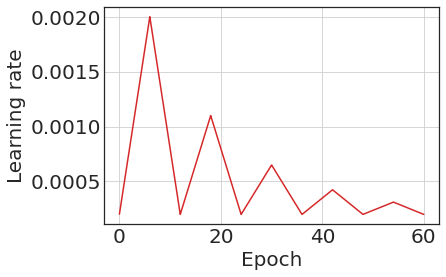

In [21]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
step_size, iterations_per_epoch = calc_step_size()
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")

Text(0.5, 45.5, 'Epochs')

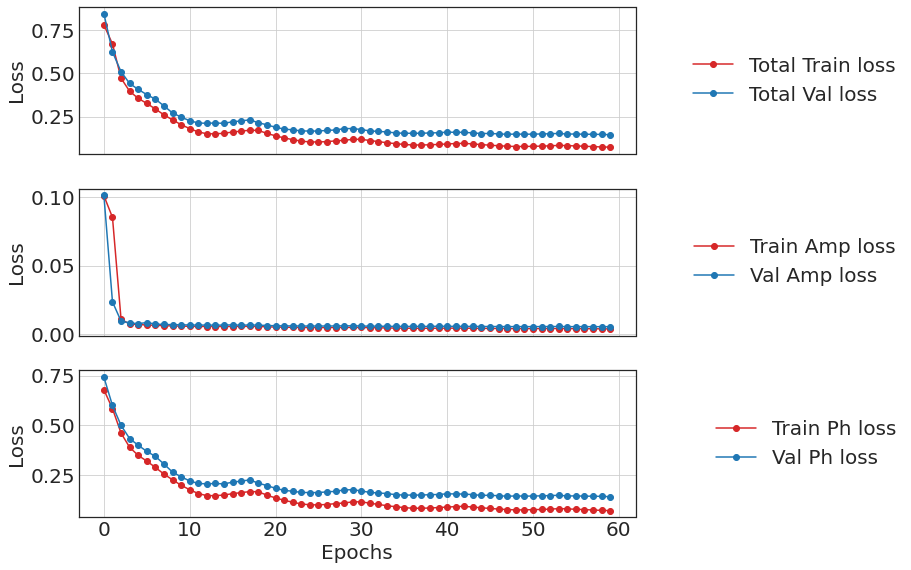

In [22]:
losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(3,sharex=True, figsize=(15, 8))
ax[0].plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax[0].plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax[0].set(ylabel='Loss')
ax[0].grid()
ax[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[1].plot(losses_arr[:,1], 'C3o-', label = "Train Amp loss")
ax[1].plot(val_losses_arr[:,1], 'C0o-', label = "Val Amp loss")
ax[1].set(ylabel='Loss')
ax[1].grid()
ax[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[2].plot(losses_arr[:,2], 'C3o-', label = "Train Ph loss")
ax[2].plot(val_losses_arr[:,2], 'C0o-', label = "Val Ph loss")
ax[2].set(ylabel='Loss')
ax[2].grid()
ax[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

plt.tight_layout()
plt.xlabel("Epochs")

In [34]:
model.eval() #imp when have dropout etc
amps = []
phs = []
for i, ft_images in enumerate(testloader):
    ft_images = ft_images[0]
    amp, ph = model(ft_images)
    for j in range(ft_images.shape[0]):
        amps.append(amp[j].detach().to("cpu").numpy())
        phs.append(ph[j].detach().to("cpu").numpy())

In [35]:
amps = np.array(amps).squeeze()
phs = np.array(phs).squeeze()
print(amps.shape, amps.dtype)
print(phs.shape, phs.dtype)

(805, 64, 64) float32
(805, 64, 64) float32


<Figure size 432x288 with 0 Axes>

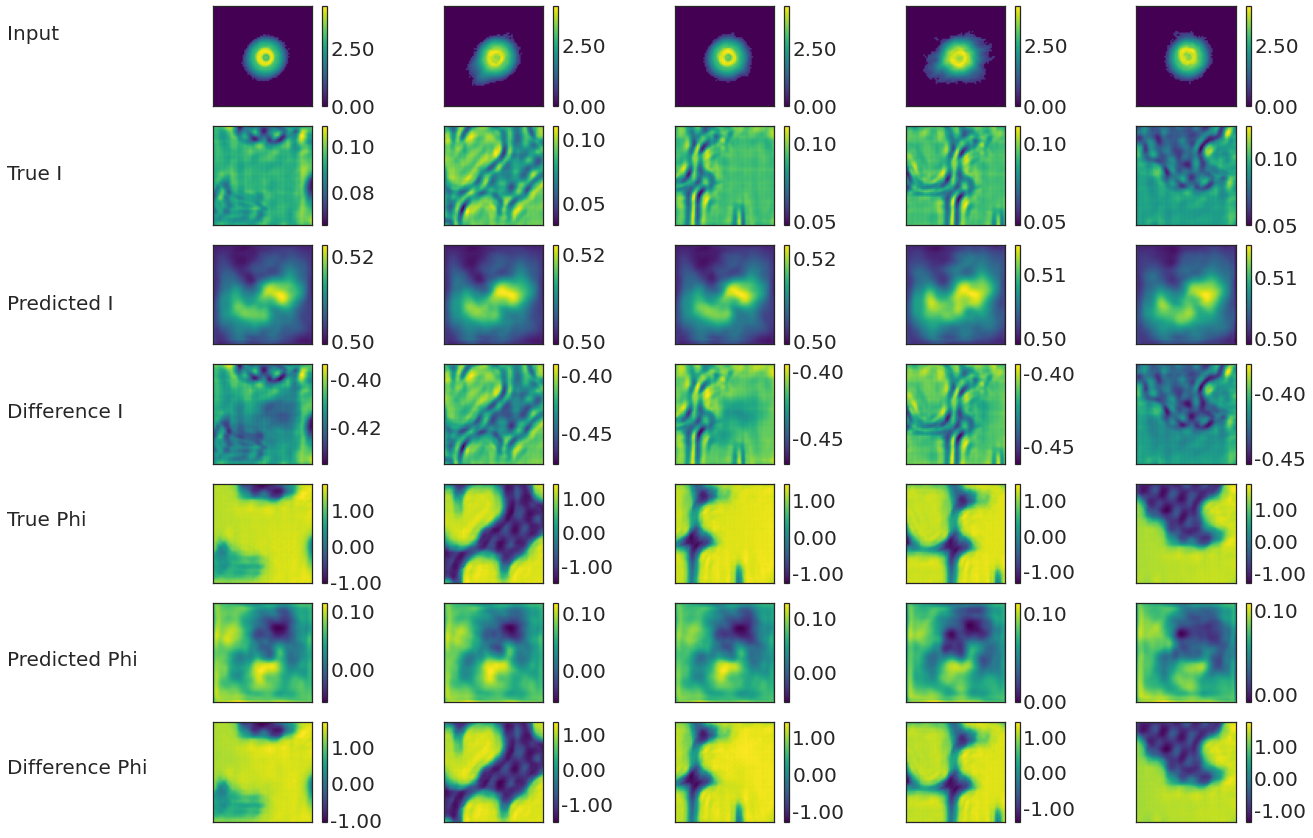

In [36]:
h,w = 64,64
ntest=amps.shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(7,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.85, "Input", fontsize=20)
plt.gcf().text(0.02, 0.72, "True I", fontsize=20)
plt.gcf().text(0.02, 0.6, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.5, "Difference I", fontsize=20)
plt.gcf().text(0.02, 0.4, "True Phi", fontsize=20)
plt.gcf().text(0.02, 0.27, "Predicted Phi", fontsize=20)
plt.gcf().text(0.02, 0.17, "Difference Phi", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

        # display FT
    im=ax[0,i].imshow(np.log10(X_test[j].reshape(h, w)+1))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(amps[j].reshape(h, w))
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
        # display original phase
    im=ax[4,i].imshow(Y_phi_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[4,i], format='%.2f')
    ax[4,i].get_xaxis().set_visible(False)
    ax[4,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[5,i].imshow(phs[j].reshape(h, w))
    plt.colorbar(im, ax=ax[5,i], format='%.2f')
    ax[5,i].get_xaxis().set_visible(False)
    ax[5,i].get_yaxis().set_visible(False)
    
    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w)-amps[j].reshape(h, w))
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
    
    # Difference in phase
    im=ax[6,i].imshow(Y_phi_test[j].reshape(h, w)-phs[j].reshape(h, w))
    plt.colorbar(im, ax=ax[6,i], format='%.2f')
    ax[6,i].get_xaxis().set_visible(False)
    ax[6,i].get_yaxis().set_visible(False)
    
plt.show()

In [26]:
point_size = 3
overlap = 4*point_size

In [27]:
tst_side = 60

composite_amp = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_amp)
data_reshaped = amps.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_amp[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [28]:

composite_phase = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_phase)
data_reshaped = phs.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_phase[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [29]:
stitched_phase = composite_phase[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp = composite_amp[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp_down = resize(stitched_amp, (60,60), preserve_range=True, anti_aliasing=True)
stitched_phase_down = resize(stitched_phase, (60,60), preserve_range=True, anti_aliasing=True)

In [30]:
true_amp = Y_I_test.reshape(NLTEST,NLTEST,64,64)
true_ph = Y_phi_test.reshape(NLTEST,NLTEST,64,64)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


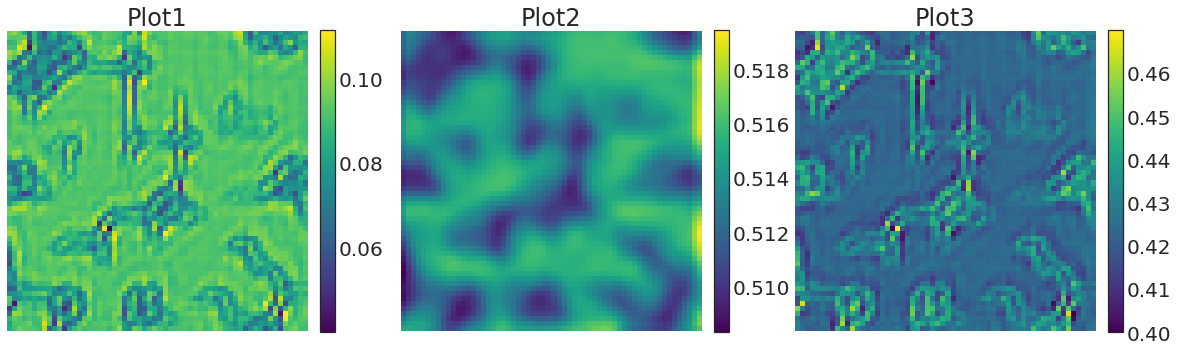

In [31]:
plot3([true_amp[:,:,32,32],stitched_amp_down,stitched_amp_down-true_amp[:,:,32,32]],[])

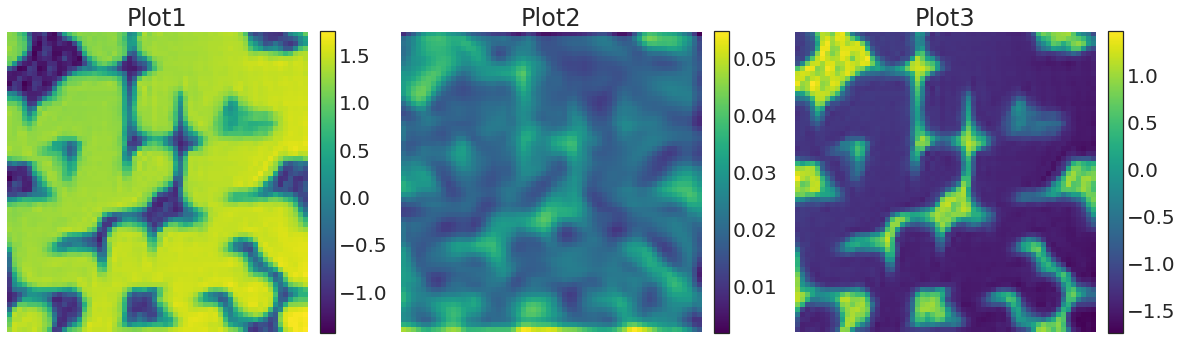

In [32]:
plot3([true_ph[:,:,32,32],stitched_phase_down,stitched_phase_down-true_ph[:,:,32,32]],[])

In [33]:
from sklearn.metrics import mean_squared_error as mse
print ("MSE in amplitude: ", mse(stitched_amp_down, true_amp[:,:,32,32]))
print ("MSE in phase: ", mse(stitched_phase_down, true_ph[:,:,32,32]))

MSE in amplitude:  0.1813600423298036
MSE in phase:  1.3686682023193477
